In [1]:
!pip install pydicom -q
!pip uninstall torch torchvision -y
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

Found existing installation: torch 2.0.0+cu118
Uninstalling torch-2.0.0+cu118:
  Successfully uninstalled torch-2.0.0+cu118
Found existing installation: torchvision 0.15.1+cu118
Uninstalling torchvision-0.15.1+cu118:
  Successfully uninstalled torchvision-0.15.1+cu118


# Configs

In [22]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [23]:
CONDITION = 'RightNeuralForaminalNarrowing'

## Load libraries

In [24]:
import os
import time
from datetime import datetime
import numpy as np
import collections
import random
import torch

from matplotlib import animation, rc
import pandas as pd

import matplotlib.pyplot as plt

## Reproducibility

In [25]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**16 - 1)
np.random.seed(hash("improves reproducibility") % 2**16 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**16 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**16 - 1)

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Directories

In [26]:
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '04_train_severity_classification', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## Functions

In [27]:
with open(os.path.join(SRC_DIR, 'pipeline_severity_classification.py')) as file:
    exec(file.read())

## Hyperparameters

In [28]:
CONFIG = dict(
    num_epochs=6,
    batch_size=50,
    lr=0.0001,
    lr_step_size=3,
    lr_gamma=0.1
)

## Metadata

In [29]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

<div style="font-size: 16px;">
    Add the cropped image path to metadata:
</div>

In [30]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

In [31]:
def get_cropped_image_path(row):
    return f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"

train_df['cropped_image_path'] = [get_cropped_image_path(row) for i, row in train_df.iterrows()]
val_df['cropped_image_path']   = [get_cropped_image_path(row) for i, row in val_df.iterrows()]

## Some example cropped images

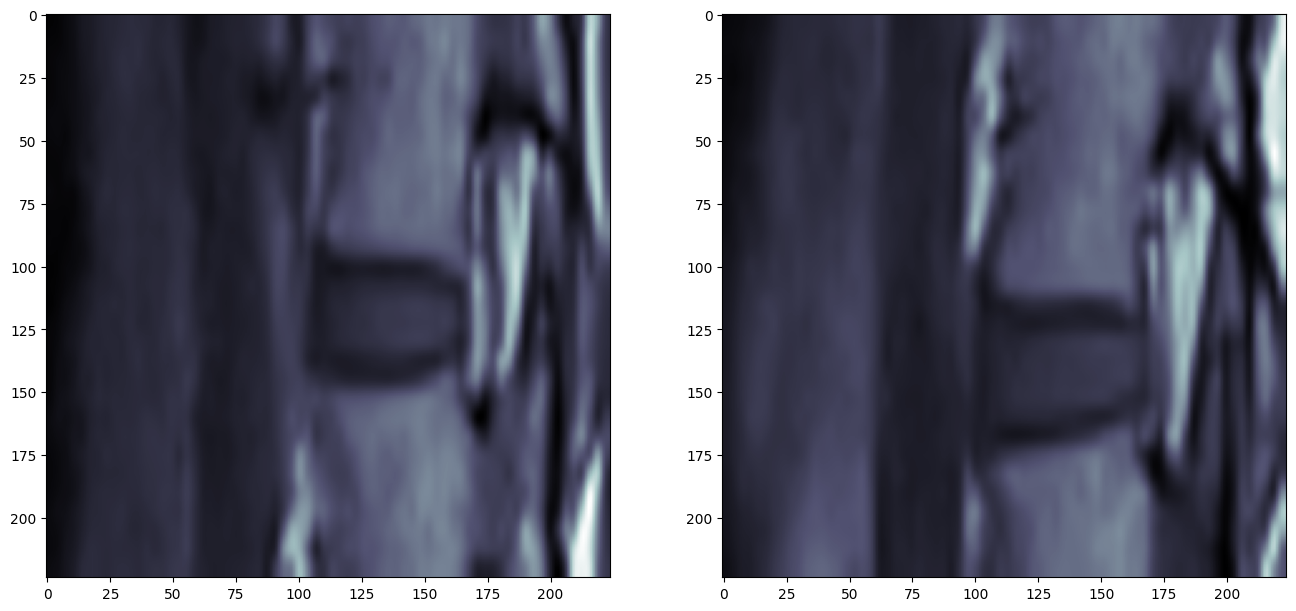

In [32]:
tmp_ds = RSNACroppedImageDataset(train_df)
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=False
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
for i, (img, label) in enumerate(tmp_dl):
    if i == 2: break
    y = img[0][0].numpy()
    ax[i].imshow(y, cmap=plt.cm.bone)
del tmp_ds, tmp_dl

# Training

## Load Model

In [33]:
model = load_model_severity_classification()

In [34]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model: {count_trainable_parameters(model)}")

Number of trainable parameters in the model: 27584877


## Test forward

In [35]:
# Create dataset and dataloader
dataset = RSNACroppedImageDataset(train_df)
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=1,
  shuffle=True
)

In [36]:
# Get first input from dataloader
images, labels = next(iter(data_loader))

# Inference
model.to('cpu')
model.eval()
with torch.inference_mode():
    predictions = model(images)

In [37]:
print(f"Predicted values for 3 classes in one sample: {predictions.squeeze().tolist()}")

Predicted values for 3 classes in one sample: [-0.18018481135368347, -0.2612112760543823, 0.1577806919813156]


## Train and validate

In [40]:
import gc
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Tue Nov 12 23:55:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             34W /   70W |    2249MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
model_pipeline(config=CONFIG, model=model, model_dir=MODEL_DIR, train_df=train_df, val_df=val_df, device=device, limit=None)

wandb: Tracking run with wandb version 0.18.6
wandb: Run data is saved locally in /home/jupyter/notebooks/wandb/run-20241112_232945-pez2nuvf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run copper-wind-36
wandb: ⭐️ View project at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: 🚀 View run at https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/pez2nuvf
  0%|          | 0/6 [00:00<?, ?it/s]

Loss after 00950 examples: 0.828
Batch 20 Metrics:
  Accuracy: 75.05%
  Class 0: Precision: 0.7874, Recall: 0.9505, F1-score: 0.8613
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: 0.0426, Recall: 0.0645, F1-score: 0.0513
Loss after 01950 examples: 0.876
Batch 40 Metrics:
  Accuracy: 76.80%
  Class 0: Precision: 0.7680, Recall: 1.0000, F1-score: 0.8688
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 02950 examples: 0.942
Batch 60 Metrics:
  Accuracy: 76.00%
  Class 0: Precision: 0.7600, Recall: 1.0000, F1-score: 0.8636
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 03950 examples: 0.953
Batch 80 Metrics:
  Accuracy: 79.10%
  Class 0: Precision: 0.7910, Recall: 1.0000, F1-score: 0.8833
  Class 1: Precision: nan, Recall: 0.0000, F1-score: 0.0000
  Class 2: Precision: nan, Recall: 0.0000, F1

 17%|█▋        | 1/6 [02:20<11:43, 140.65s/it]

Validation Metrics:
  Loss: 0.8189
  Accuracy: 66.29%
  Class 0: Precision: 0.8817, Recall: 0.6961, F1-score: 0.7780
  Class 1: Precision: 0.3217, Recall: 0.6597, F1-score: 0.4325
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 08020 examples: 0.810
Batch 20 Metrics:
  Accuracy: 72.53%
  Class 0: Precision: 0.8259, Recall: 0.8562, F1-score: 0.8408
  Class 1: Precision: 0.3118, Recall: 0.3412, F1-score: 0.3258
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 09020 examples: 0.707
Batch 40 Metrics:
  Accuracy: 71.90%
  Class 0: Precision: 0.8496, Recall: 0.8173, F1-score: 0.8331
  Class 1: Precision: 0.3099, Recall: 0.4438, F1-score: 0.3650
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 10020 examples: 0.946
Batch 60 Metrics:
  Accuracy: 74.80%
  Class 0: Precision: 0.8808, Recall: 0.8244, F1-score: 0.8517
  Class 1: Precision: 0.3889, Recall: 0.5707, F1-score: 0.4626
  Class 2: Precision: nan, Recall: 0.0000, F1-score:

 33%|███▎      | 2/6 [04:42<09:24, 141.19s/it]

Validation Metrics:
  Loss: 0.7237
  Accuracy: 73.10%
  Class 0: Precision: 0.8872, Recall: 0.7998, F1-score: 0.8412
  Class 1: Precision: 0.3737, Recall: 0.5966, F1-score: 0.4595
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 15090 examples: 0.612
Batch 20 Metrics:
  Accuracy: 74.63%
  Class 0: Precision: 0.9010, Recall: 0.8056, F1-score: 0.8507
  Class 1: Precision: 0.3816, Recall: 0.6316, F1-score: 0.4758
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 16090 examples: 0.728
Batch 40 Metrics:
  Accuracy: 77.30%
  Class 0: Precision: 0.9003, Recall: 0.8516, F1-score: 0.8752
  Class 1: Precision: 0.3871, Recall: 0.5890, F1-score: 0.4672
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 17090 examples: 0.847
Batch 60 Metrics:
  Accuracy: 76.30%
  Class 0: Precision: 0.9015, Recall: 0.8258, F1-score: 0.8620
  Class 1: Precision: 0.3866, Recall: 0.6228, F1-score: 0.4771
  Class 2: Precision: nan, Recall: 0.0000, F1-score:

 50%|█████     | 3/6 [07:04<07:04, 141.53s/it]

Validation Metrics:
  Loss: 0.6272
  Accuracy: 78.14%
  Class 0: Precision: 0.9134, Recall: 0.8423, F1-score: 0.8764
  Class 1: Precision: 0.4556, Recall: 0.6891, F1-score: 0.5485
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 22160 examples: 0.475
Batch 20 Metrics:
  Accuracy: 80.21%
  Class 0: Precision: 0.9121, Recall: 0.8736, F1-score: 0.8924
  Class 1: Precision: 0.4857, Recall: 0.6611, F1-score: 0.5600
  Class 2: Precision: nan, Recall: 0.0000, F1-score: 0.0000
Loss after 23160 examples: 0.461
Batch 40 Metrics:
  Accuracy: 79.70%
  Class 0: Precision: 0.9279, Recall: 0.8536, F1-score: 0.8892
  Class 1: Precision: 0.4318, Recall: 0.6826, F1-score: 0.5290
  Class 2: Precision: 1.0000, Recall: 0.0294, F1-score: 0.0571
Loss after 24160 examples: 0.556
Batch 60 Metrics:
  Accuracy: 82.60%
  Class 0: Precision: 0.9346, Recall: 0.8936, F1-score: 0.9136
  Class 1: Precision: 0.4723, Recall: 0.6937, F1-score: 0.5620
  Class 2: Precision: 1.0000, Recall: 0.0244, F1-

 67%|██████▋   | 4/6 [09:26<04:43, 141.94s/it]

Validation Metrics:
  Loss: 0.6109
  Accuracy: 81.18%
  Class 0: Precision: 0.9045, Recall: 0.8942, F1-score: 0.8993
  Class 1: Precision: 0.5175, Recall: 0.5588, F1-score: 0.5374
  Class 2: Precision: 0.4872, Recall: 0.4043, F1-score: 0.4419
Loss after 29230 examples: 0.508
Batch 20 Metrics:
  Accuracy: 81.89%
  Class 0: Precision: 0.9409, Recall: 0.8814, F1-score: 0.9102
  Class 1: Precision: 0.4536, Recall: 0.5570, F1-score: 0.5000
  Class 2: Precision: 0.4643, Recall: 0.6190, F1-score: 0.5306
Loss after 30230 examples: 0.532
Batch 40 Metrics:
  Accuracy: 82.70%
  Class 0: Precision: 0.9251, Recall: 0.8906, F1-score: 0.9075
  Class 1: Precision: 0.5253, Recall: 0.5714, F1-score: 0.5474
  Class 2: Precision: 0.5741, Recall: 0.7561, F1-score: 0.6526
Loss after 31230 examples: 0.496
Batch 60 Metrics:
  Accuracy: 84.50%
  Class 0: Precision: 0.9323, Recall: 0.9018, F1-score: 0.9168
  Class 1: Precision: 0.5641, Recall: 0.6286, F1-score: 0.5946
  Class 2: Precision: 0.5135, Recall: 0.612

 83%|████████▎ | 5/6 [11:48<02:21, 141.93s/it]

Validation Metrics:
  Loss: 0.6206
  Accuracy: 82.55%
  Class 0: Precision: 0.8963, Recall: 0.9232, F1-score: 0.9096
  Class 1: Precision: 0.5640, Recall: 0.5000, F1-score: 0.5301
  Class 2: Precision: 0.4889, Recall: 0.4681, F1-score: 0.4783
Loss after 36300 examples: 0.372
Batch 20 Metrics:
  Accuracy: 82.84%
  Class 0: Precision: 0.9456, Recall: 0.8742, F1-score: 0.9085
  Class 1: Precision: 0.5121, Recall: 0.6503, F1-score: 0.5730
  Class 2: Precision: 0.4667, Recall: 0.6562, F1-score: 0.5455
Loss after 37300 examples: 0.347
Batch 40 Metrics:
  Accuracy: 84.80%
  Class 0: Precision: 0.9220, Recall: 0.9220, F1-score: 0.9220
  Class 1: Precision: 0.5823, Recall: 0.5257, F1-score: 0.5526
  Class 2: Precision: 0.4894, Recall: 0.7667, F1-score: 0.5974
Loss after 38300 examples: 0.457
Batch 60 Metrics:
  Accuracy: 82.60%
  Class 0: Precision: 0.9278, Recall: 0.8938, F1-score: 0.9105
  Class 1: Precision: 0.5158, Recall: 0.5568, F1-score: 0.5355
  Class 2: Precision: 0.4375, Recall: 0.636

100%|██████████| 6/6 [14:12<00:00, 142.04s/it]

Validation Metrics:
  Loss: 0.5752
  Accuracy: 78.78%
  Class 0: Precision: 0.9219, Recall: 0.8454, F1-score: 0.8820
  Class 1: Precision: 0.4647, Recall: 0.6092, F1-score: 0.5273
  Class 2: Precision: 0.4528, Recall: 0.5106, F1-score: 0.4800



wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      accuracy ▃▄▃▅▄▅▂▁▁▃▂▂▂▂▂▄▃▃▄▃▅▅▇▅▆▆▅▆▇█▅▆▇▇▇█▇▇█▇
wandb:         epoch ▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
wandb:          loss ▆▇▇█▅█▅▆▅▇▅▆▆▅▄▅▆▅▆▆▃▂▃▂▃▂▂▃▃▃▃▃▄▁▂▁▂▃▂▄
wandb: test_accuracy ▁▄▆▇█▆
wandb:     test_loss █▅▂▂▂▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.827
wandb:         epoch 5
wandb:          loss 0.63948
wandb: test_accuracy 0.78783
wandb:     test_loss 0.57523
wandb: 
wandb: 🚀 View run copper-wind-36 at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo/runs/pez2nuvf
wandb: ⭐️ View project at: https://wandb.ai/ning-shen-university-of-british-columbia/pytorch-demo
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241112_232945-pez2nuvf/logs


<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by epoch 6 because it has the lowest validation loss and highest validation accuracy!
</strong></div>